In [1]:
from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import os

import tensorflow as tf
import json
import time

import gymnasium as gym

# Sample Running CartPole-v1 [No Algorithm]

In [ ]:
# environment_name = 'CartPole-v1'
# env = gym.make(environment_name, render_mode="human")

# episodes = 30
# for episodes in range(1, episodes+1):
#     state = env.reset()
#     done = False
#     score = 0

#     while not done:
#         env.render()
#         action = env.action_space.sample()
#         n_state, reward, done, truncated, info = env.step(action)
#         score += reward
#     print('Episode:{} Score:{}'.format(episodes, score))
# # env.close()

In [4]:
# env.close()

## Implementing Q-Learning

In [2]:
class CartPoleAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.v_values = defaultdict(lambda: np.zeros(1))
        self.v_policy = defaultdict(lambda: np.zeros(1))

        self.N_q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.N_v = defaultdict(lambda: np.zeros(1))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs, policy) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """        
        action_probs = policy[obs]
        action = np.random.choice(len(action_probs), p=action_probs)
        
        return action

    def update(
        self,
        obs: tuple[int, int, int, int],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, int, int],
        next_action: int,
    ):
        """Updates the Q-value of an action."""
        # print("b",obs)
        # print("c",next_obs)
        future_q_value = (not terminated) * self.q_values[next_obs][next_action]
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

    def save_model(self, path, filename):
        # Save model parameters to a JSON file
        model_params = {
            'q_values': self.q_values.tolist(),
            # 'biases': self.biases.tolist()
        }
        full_path = os.path.join(path, filename)
        with open(full_path, 'w') as f:
            json.dump(model_params, f)

    def load_model(self, filename):
        # Load model parameters from a JSON file
        with open(filename, 'r') as f:
            model_params = json.load(f)
        self.weights = np.array(model_params['weights'])
        self.biases = np.array(model_params['biases'])

In [25]:
# def map_discrete_state(cs, reward):
#     ds_vector = np.zeros(4)
#     # Discretize Position
#     # if abs(cs[0]) <= 2.3:
#     #     ds_vector[0] = 0
#     # elif abs(cs[0]) > 2.3:
#     #     ds_vector[0] = 0
#     #     reward -= 1

#     if abs(cs[2]) <= 0.10:
#         if cs[2] <= 0.0:
#             state = 0
#             # print("soft_lean_left")
#         elif cs[2] > 0.0:
#             state = 1
#             # print("soft_lean_right")
#         reward += 1

#     elif abs(cs[2]) > 0.1 and abs(cs[2]) <= 0.2:
#         if cs[2] <= 0.0:
#             state = 2
#             # print("hard_lean_left")
#         elif cs[2] > 0.0:
#             state = 3
#             # print("hard_lean_right")
#         reward += 0

#     elif abs(cs[2]) > 0.2:
#         state = 4
#         # print("fallen")
#         reward -= 1
    
#     return state, reward

In [3]:
def map_discrete_state(cs):
    cs[0] = int(cs[0] * 10)
    cs[1] = int(cs[1] * 10)
    cs[2] = int(cs[2] * 10)
    cs[3] = int(cs[3] * 10)
    
    ds = tuple(cs)
    return ds

### Reward Function

In [4]:
def reward_function(ds, culmulative_reward, dt, targetAngle):

    angle_fixrate = np.deg2rad(1.0)

    if ds[0] < targetAngle:
        targetAngle += angle_fixrate * dt
    else:
        targetAngle -= angle_fixrate * dt

    error_cart_pos = 0 - abs(ds[0])

    error_pole_pos = 0 - abs(ds[2])

    time_reward = (culmulative_reward)/500
    # print("time_reward", time_reward)

    reward = error_pole_pos 

    return reward

## Train RL Model

### Save log

In [153]:
log_path = os.path.join('Training', 'Logs')

In [154]:
print(log_path)

Training\Logs


### Q-Learning

In [15]:
environment_name = 'CartPole-v1'
env = gym.make(environment_name, render_mode="human")
# env = gym.make(environment_name)

In [13]:
# hyperparameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.01

discount = 1

agent = CartPoleAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [11]:
print(len([2,2]))

2


In [ ]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

dis_play_list =[]

N = defaultdict(lambda: np.zeros(env.action_space.n))
return_sum = defaultdict(lambda: np.zeros(env.action_space.n))

policy = defaultdict(lambda: np.full(env.action_space.n, 0.5))

w = defaultdict(lambda: np.zeros(1))

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    score = 0
    discrete_state = (0, 0, 0, 0)
    discrete_reward = 0
    new_discrete_state = [0, 0, 0, 0]
    iteration = 0

    prev_time = 0

    targetAngle = 0

    history_ls = []

    # play one episode
    while not done:
        env.render()
        # Choose a from s using policy derived from Q
        discrete_state = map_discrete_state(obs)
        action = agent.get_action(discrete_state, policy)

        obs, reward, terminated, truncated, info = env.step(action)

        new_discrete_state = map_discrete_state(obs)
        score += reward

        present_time = time.time()
        delta_time = present_time - prev_time
        prev_time = present_time

        discrete_reward = reward_function(new_discrete_state, score, delta_time, targetAngle)

        history_ls.append([discrete_state, action, discrete_reward])

        # Choose next a from next s using policy derived from Q
        # new_action = agent.get_action(new_discrete_state, policy)

        # update the agent
        # agent.update(discrete_state, action, reward, terminated, new_discrete_state, new_action)
        

        # update if the environment is done and the current obs
        done = terminated or truncated
        # print("terminated: ", terminated, "truncated", truncated)
        # if done == True:
        #     print("reward: ", discrete_reward)
        # obs = next_obs
    
    G = 0
    St = 0
    At = 0
    for i in reversed(range(len(history_ls)-1)):
        St = history_ls[i][0]
        At = history_ls[i][1]
        G = discount*G + history_ls[i][2]

        # Update state value function
        agent.N_v[St] += 1
        agent.v_values[St] = agent.v_values[St] + (G - agent.v_values[St])/agent.N_v[St]
        w[St][At] = w[St] + agent.lr*(G - w[St])

        # Update state-action value function
        # agent.N_q[St][At] += 1
        # agent.q_values[St][At] = agent.q_values[St][At] + (G - agent.q_values[St][At])/agent.N_q[St][At]

        if agent.v_values[St] >= agent.v_policy[St]:
            if i == 0:
                agent.v_policy = np.copy(agent.v_values)

                for j in reversed(range(len(history_ls)-1)):
                    St = history_ls[j][0]
                    At = history_ls[j][1]
                    for i in range(len(policy[St])):
                        if i == At:
                            policy[St][i] = 1
                        else:
                            policy[St][i] = 0
        else:
            break
        
        

    dis_play_list.append(score)

    agent.decay_epsilon()

In [51]:
env.close()

In [50]:
np.argmax(agent.q_values[0])

0

In [37]:
def iterate_backward(my_list):
    for i in reversed(range(len(my_list)-1)):
        yield i

# Example usage:
my_list = [1, 2, 3, 1, 1]
for item in iterate_backward(my_list):
    print(item)

3
2
1
0


In [81]:
env.close()

In [30]:
len(agent.q_values)

28519

In [42]:
display_np = np.array(dis_play_list)
print(display_np)

[-102. -147. -177. ... -375. -154. -241.]


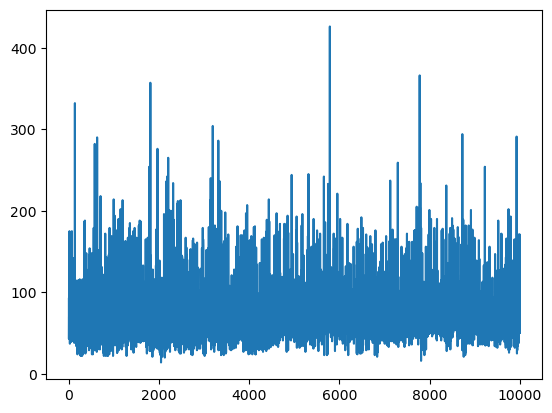

In [150]:
display_np = np.array(dis_play_list)

t = np.linspace(1, 9999, 9999)

plt.plot(t, display_np[90000:99999])
plt.show() 

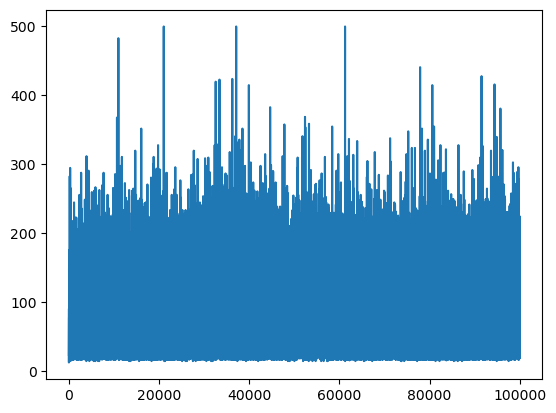

In [68]:
display_np = np.array(dis_play_list)

t = np.linspace(1, len(display_np), len(display_np))

plt.plot(t, display_np)
plt.show() 

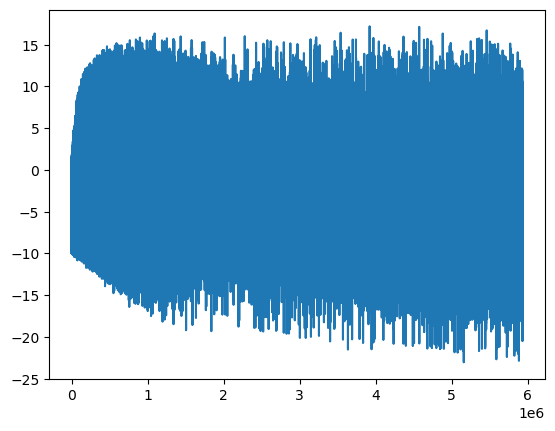

In [131]:
display_np = np.array(dis_play_list)

t = np.linspace(1, len(agent.training_error), len(agent.training_error))

plt.plot(t, agent.training_error)
plt.show() 

#### Save Model

In [ ]:
Q_Learning_Path = os.path.join('Training', 'Save Models', 'Q_Learning_Model_Cartpole')

In [ ]:
agent.save